# IM970 DataScience

## Mikro-Projekt: "Banane"

[quelle: siehe KW48](http://jbusse.de/2019_ws_dsci/im970-termine.html)

### Aufgabe

Vorhersage des Nettogewichtes von Bananen auf Grundlage von Länge(n), Dicke

**Lernziele**:

- das bisherige Wissen auf ein triviales Spiel-Beispiel anwenden
- Nutzung von [sklearn.linear_model.ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV)
- [Aufbau nach CRISP-DM](http://jbusse.de/2019_ws_dsci/dsci-ressourcen.html#crisp-dm-model) ([src2](https://www.the-modeling-agency.com/crisp-dm.pdf))
- möglichst wenig Code-Zeilen verwenden

**Lernziele**:  
An einer 08/15-Aufgabe sehr methodisch den kompletten Pfad von Datenschöpfung, Feature Engineering, Modellkonstruktion bis hin zur Modellevaluation durch gehen - idealerweise mit möglichst wenig Code, aber viel Grips und Erklärung.

## Abgabe

Aufgabe: Notebook Teil 2: "Codieren"  
Student: ..., **Mat.Nr. ...**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
import pandas as pd
import math

In [3]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score

In [4]:
from sklearn.decomposition import PCA

## Business Understanding

### Determine Business Objectives

#### Background and Business Objectives:

Wir sind zuständig für eine neue, maßgeblich auf Bananen basierte Diät bei Weightwatchers.  
Damit wir unseren Kundinnen und Kunden den maßgeschneiderten Kaloriensatz ihres täglichen Essens berechnen können, *müssen wir dazu als Grundlage das Netto-Gewicht der verzehrten Banane(n) bestimmen*. Davon werden dann alle weiteren Informationen abgeleitet.

Fragestellung: **"Kann anhand der Außenmaße das Nettogewicht bestimmt werden?"**

#### Business success criteria

Das Ziel ist erreicht, wenn die Gewichtsvorhersage nur eine minimale Abweichung vom tatsächlichen Gewicht erzielt.  
Minimal entspricht einer Abweichung von +/-5 % vom Mittelwert.

### Assess Situation

#### Inventory of Resources

*data*:

- BananenHansLohninger-dsciKw48.csv

*software*:

- python==3.7.4
  - sklearn==0.21.3
  - seaborn==0.9.0
  - matplotlib==3.1.1

*data scientist*: M.S.

#### Requirements, Assumptions, and Constraints

schedule of completion: '2019.12.03 23:59'  
comprehensibility and quality of results: error in g (Gramm) is enough  
security: none  
legal issues: *be aware to not plagiate*

```
[src](www.statistics4u.com/fundstat_germ/$lit_LOHPRIV10.html)
Authors: 	H. Lohninger  
Title: 	Basic properties of bananas.  
Reference: 	Private communcations, Vienna University of Technology, Vienna, Austria, 2010
```

**Assumption I:** Das Gewicht kann über Länge und Durchmesser genähert werden, da Bananen ein nahezu gleiches Gewicht pro cm^3 vorweisen (Dichte ist annähernd gleich).

**Assumption II:** Die Datenmenge ist nicht sonderlich groß - dennoch können die Beispiele verwendet werden um eine valide Näherung zu produzieren.

#### Risks and Contingencies

*None*

#### Terminology

*None*

#### Costs and Benefits

*None*

### Determine Data Mining Goals

*Kein datamining Projekt*

### Produce project plan

*Kein Projektplan nötig, da es sich um ein "Mini-Projekt" handelt.*

## Data understanding

### Collect Initial Data

Create initial data collection report

Daten lokal unter: './data/BananenHansLohninger-dsciKw48.csv', [Quelle:](http://jbusse.de/2019_ws_dsci/ipynb-tasks/data/BananenHansLohninger-dsciKw48.csv)

In [5]:
df_orig = pd.read_csv(
    './data/BananenHansLohninger-dsciKw48.csv',
    sep=';', index_col="id"
)
print("df_orig.shape {}".format(df_orig.shape))

df_orig.shape (38, 5)


In [6]:
df = df_orig.copy()

### Describe Data

[Quelle Datenbeschreibung](http://www.statistics4u.com/fundstat_germ/data_bananas.html)

Features:

- SkinWeight: Gewicht der Schale
- Length: Länge der Banane
- Width: Dicke der Banane
- OuterLength: äußere Länge entlang des Rückens der Banane
- NetWeight: Nettogewicht der Banane als Differenz von Gesamtgewicht und Gewicht der Schale (hier: Gesamtgewicht fehlt)

In [7]:
df.head()

,SkinWeight,Length,Width,OuterLength,NetWeight
id,,,,,
5,61,165,38.0,226,111
9,51,143,39.0,224,99
14,70,183,40.0,275,136
15,72,167,41.0,269,126
16,74,218,39.0,277,156


In [8]:
# überprüfen, ob alle "id"s unique() sind 
# ... ggf. wäre Fehler bereits bei pd.read_ aufgetreten
len(df.index.unique())

38

In [9]:
df.info(verbose=True);

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 5 to 49
Data columns (total 5 columns):
SkinWeight     38 non-null int64
Length         38 non-null int64
Width          33 non-null float64
OuterLength    38 non-null int64
NetWeight      38 non-null int64
dtypes: float64(1), int64(4)
memory usage: 1.8 KB


In [10]:
df.describe()

,SkinWeight,Length,Width,OuterLength,NetWeight
count,38.000000,38.000000,33.000000,38.000000,38.000000
mean,64.026316,318.921053,38.090909,234.105263,106.921053
std,13.831978,328.291678,2.082121,29.393683,23.024525
min,42.000000,121.000000,34.000000,179.000000,70.000000
25%,50.250000,152.750000,37.000000,211.750000,86.000000
50%,63.000000,173.500000,38.000000,236.500000,108.000000
75%,73.500000,193.750000,40.000000,255.750000,119.750000
max,88.000000,999.000000,42.000000,288.000000,159.000000


### Verify Data Quality

*vergezogen um ggf. Nan's herauszufilter

In [11]:
df.isna().any()

SkinWeight     False
Length         False
Width           True
OuterLength    False
NetWeight      False
dtype: bool

In [12]:
df[~df['Width'].isna()].shape

(33, 5)

In [13]:
# df[df['Width'].isna()]

### Describe Data

Ausschließlich **numerische** Features, welche keine **Ausreißer** enthalten.

Verteilungen (visuell ermittelt) der einzelnen Features: (**Vorsicht: kleines Sample!**)

- SkinWeight: normalverteilt
  - mean: 64.03, std: 13.83
- Length: bimodal verteilt
  - mean: 318.92, std: 328.29 [*unbrauchbar...*]
  - Werte: 999 # Ausreisser?
- Width: normalverteilt
  - mean: 38.09, std: 2.08
- OuterLength: normalverteilt
  - mean: 234.11, std: 29.39
- NetWeight: normalverteilt, leicht linksschief
  - mean: 106.92, std: 23.02

*Informationen auch aus: Explore data*

### Explore Data

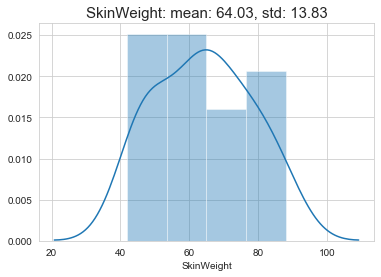

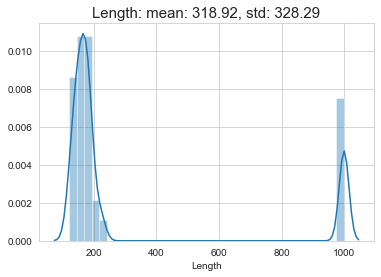

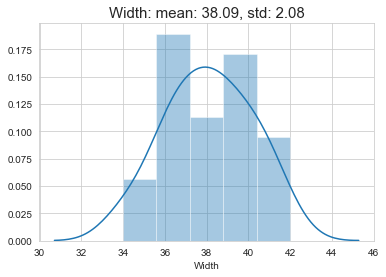

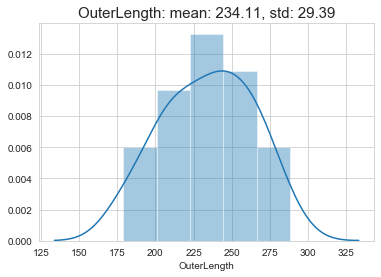

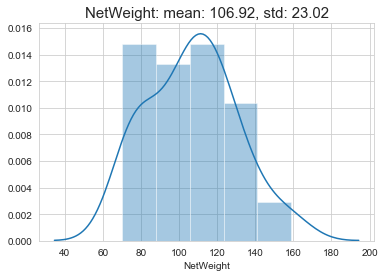

In [14]:
# verwende nur Zeilen, wo Weigth != nan
for col in df.columns:
    sns.distplot(df[~df[col].isna()][col]);
    plt.title(
        "{}: mean: {:.2f}, std: {:.2f}".format(
            col,
            df[~df[col].isna()][col].mean(),
            df[~df[col].isna()][col].std()
        ),
        size=15
    );
    plt.show()

In [15]:
df["LengthGrp"] = pd.np.where(df["Length"] <= 600,0,1)
print("Length > 600 == 1")
df["LengthGrp"].value_counts()

Length > 600 == 1


0    31
1     7
Name: LengthGrp, dtype: int64

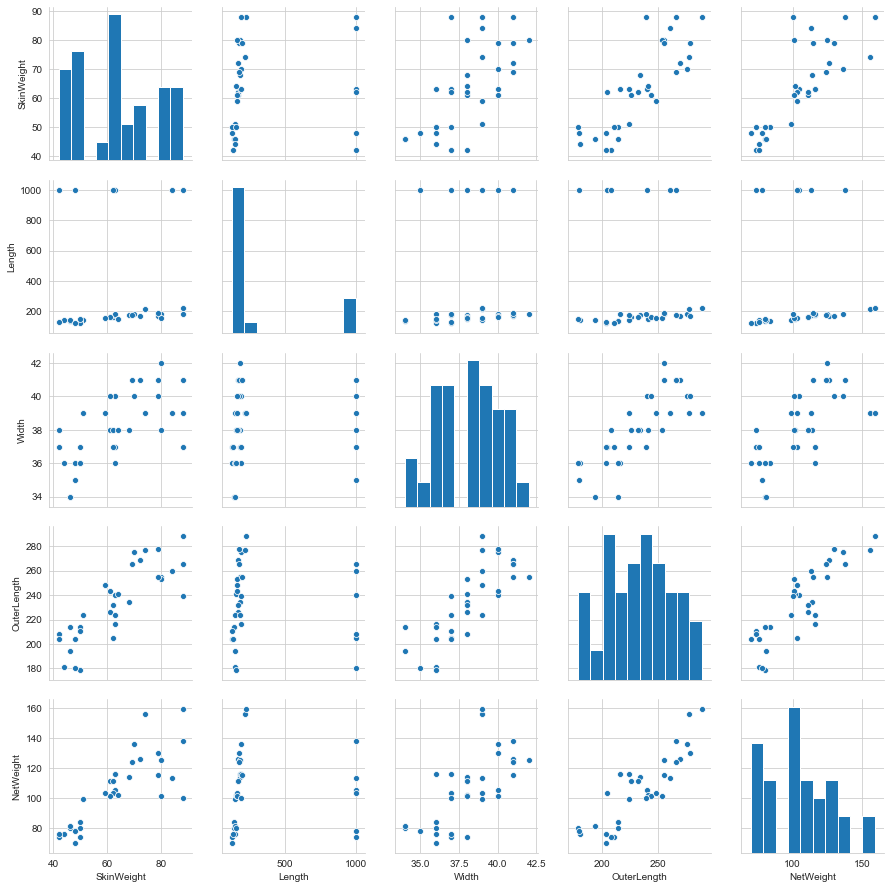

In [16]:
# verwende nur Zeilen, wo Weigth != nan
sns.pairplot(
    df[~df['Width'].isna()][
        ['SkinWeight', 'Length', 'Width', 'OuterLength', 'NetWeight']
    ]
);

**Beschreibung:** PairPlot stellt die einzelnen Features visuell gegenüber.  
**Analyse:**

- Korrelation zwischen SkinWeight und NetWeight
- Leichte Korrelation zwischen SkinWeight und Width
- Korrelation zwischen SkinWeight und OuterLength


- sehr leichte Korrelation zwischen Length (<600) und anderen Features zu erkennen (mehr Datenpunkte)


- Korrelation zwischen Width und OuterLength
- *Korrelation* zwischen Width und NetWeigth


- Korrelation OuterLength und NetWeight

**PairPlot mit hue='LengthGrp'**:

- Length verursacht keine Verteilungsunterschiede die nicht auch durch mangelnde Samples entstehen könnten 

C:\Users\sachs\.conda\envs\datascience\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\sachs\.conda\envs\datascience\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


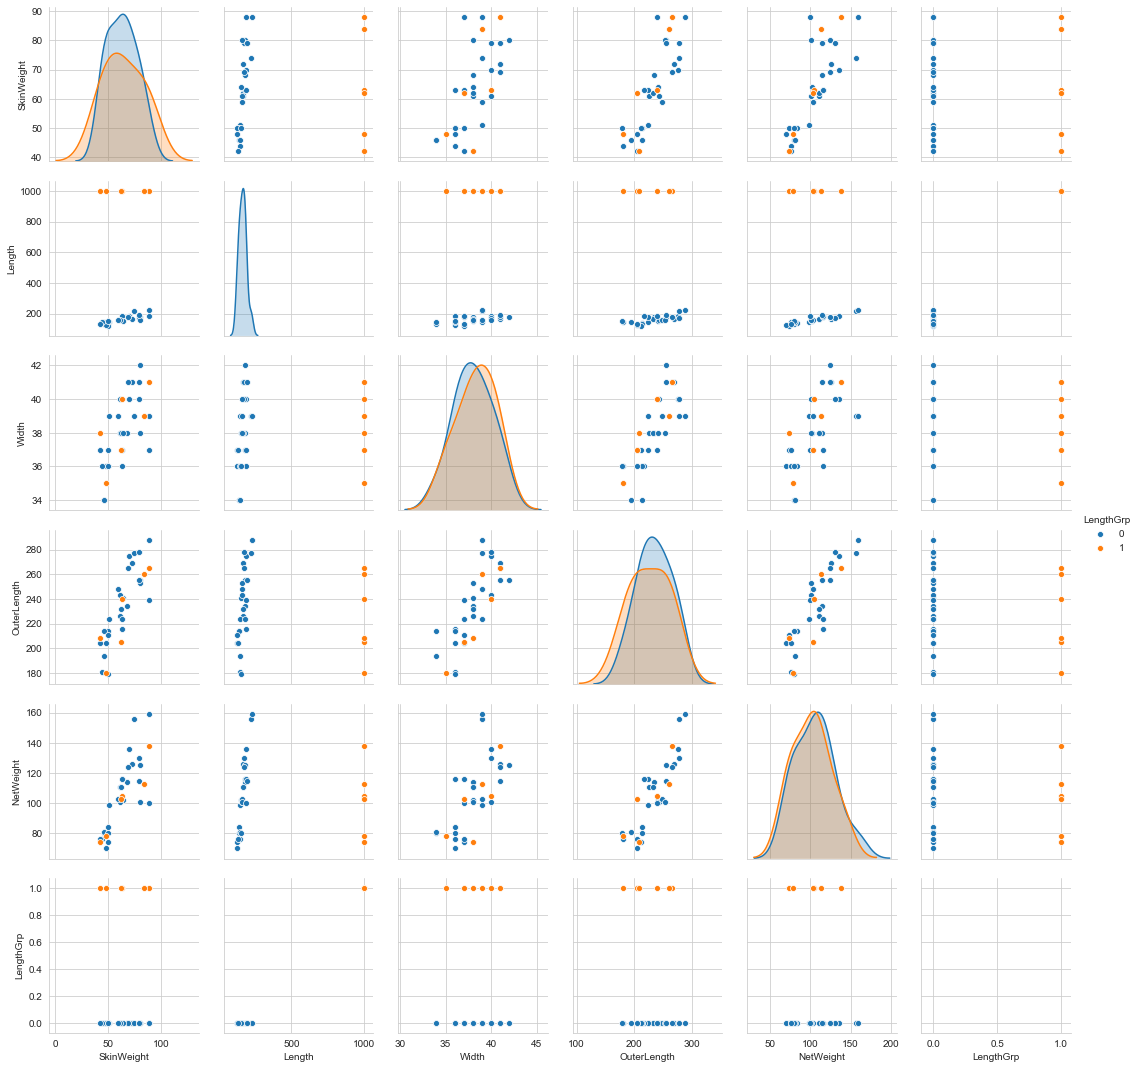

In [17]:
# verwende nur Zeilen, wo Weigth != nan
sns.pairplot(
    df[~df['Width'].isna()][
        ['SkinWeight', 'Length', 'Width', 'OuterLength', 'NetWeight', 'LengthGrp']
    ],
    hue="LengthGrp"
);

**Korrelationsplot ('Pearson'):**  
Vorlage: [src](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)

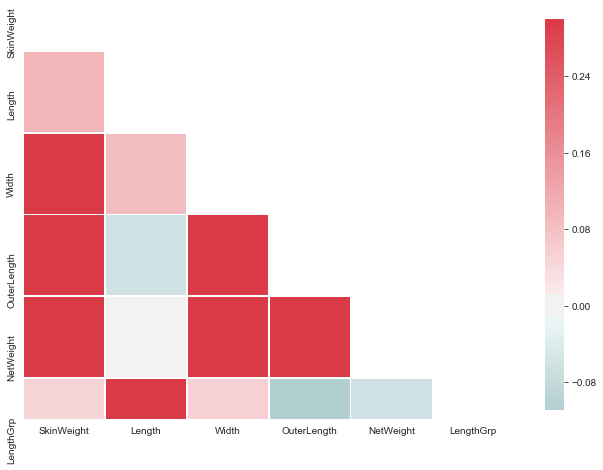

In [18]:
# Compute the correlation matrix
corr = df.corr()  # 'spearman'

# Generate a mask for the upper triangle
mask = pd.np.zeros_like(corr, dtype=pd.np.bool)
mask[pd.np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)
# cmap = sns.choose_diverging_palette(as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr, mask=mask, cmap=cmap,
    vmax=.3,
    center=0,
    square=True,
    linewidths=.8,
    cbar_kws={"shrink": .8} # fuer legende
);

**Beschreibung:** Korrelations-HeatMap zeigt zusammenhänge an (Pearson-Korr-Koeff)  
**Analyse:** Die Zusammenhänge aus der visuellen-Analyse spiegeln sich wieder, wenn auch die KorrelationsKoeffizienten niedrig sind (< 0.5!)


 

## Data Preparation

### Select Data

...

In [19]:
df = df[['Length', 'Width', 'OuterLength', 'NetWeight']]

### Clean data

In [20]:
df_cleaned = df[(~df['Width'].isna())&(df['Length'] < 950)]
print("df_cleaned.shape {}".format(df_cleaned.shape))

df_cleaned.shape (27, 4)


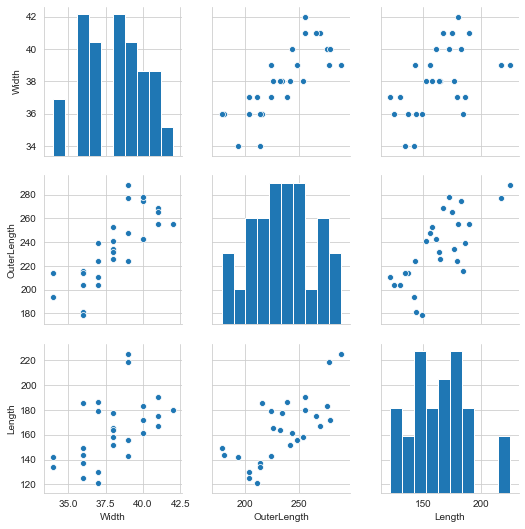

In [21]:
sns.pairplot(df_cleaned[['Width','OuterLength','Length']]);

Imputiere fehlende Werte (nan) in "Weight" mit multivariate-feature-imputation [src](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation)

code [src](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation)

**setze Length-Werte >950 gleich None, fuer Imputer**

In [22]:
df_imp = df.copy()
df_imp.loc[df_imp['Length'] > 950] = None

In [23]:
imp = IterativeImputer(max_iter=10, random_state=13)

In [24]:
cols = ['Length', 'Width', 'OuterLength']
df_imp = imp.fit_transform(df_imp[cols])
df_imp = pd.DataFrame(data=df_imp, columns=cols, index=df.index)

In [25]:
df_imp.isna().any()

Length         False
Width          False
OuterLength    False
dtype: bool

In [26]:
df_imp = pd.concat([df_imp, df['NetWeight']], axis=1)

In [27]:
df_imp.head()

,Length,Width,OuterLength,NetWeight
id,,,,
5,165.0,38.0,226.0,111
9,143.0,39.0,224.0,99
14,183.0,40.0,275.0,136
15,167.0,41.0,269.0,126
16,218.0,39.0,277.0,156


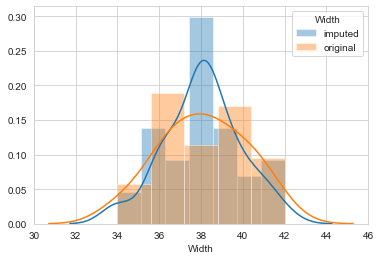

In [28]:
sns.distplot(df_imp["Width"]);
sns.distplot(df[df["Width"].notna()]["Width"]);
plt.legend(
    title='Width',
    loc='upper right',
    labels=['imputed', 'original']
)
plt.show();

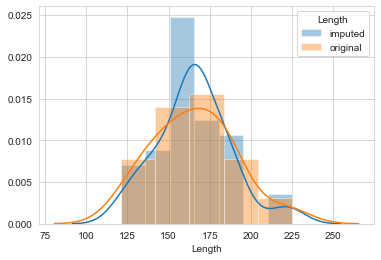

In [29]:
sns.distplot(
    df_imp[df_imp["Length"] < 950]["Length"]
);
sns.distplot(
    df[
        (df["Length"].notna()) & (df["Length"] < 950)
    ]["Length"]
);
plt.legend(
    title='Length',
    loc='upper right',
    labels=['imputed', 'original']
)
plt.show();

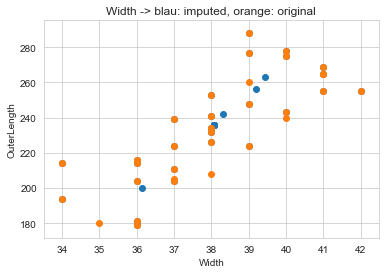

In [30]:
plt.scatter(df_imp["Width"], df_imp["OuterLength"]);
plt.scatter(df["Width"], df["OuterLength"]);
plt.xlabel('Width');
plt.ylabel('OuterLength');
plt.title("Width -> blau: imputed, orange: original");
plt.show();

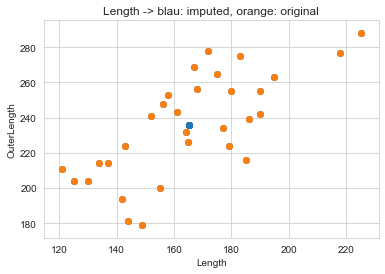

In [31]:
plt.scatter(df_imp["Length"], df_imp["OuterLength"]);
plt.scatter(df[df["Length"] < 950]["Length"], df[df["Length"] < 950]["OuterLength"]);
plt.xlabel('Length');
plt.ylabel('OuterLength');
plt.title("Length -> blau: imputed, orange: original");
plt.show();

### Construct Data

**Derived Attributes:**

- ~~TotalWeight = NetWeight + SkinWeight~~
  - würde NetWeight in X (Features) enkodieren
- Volume = VolumeEnds + VolumeBody
  - VolumeEnds = 4/3 * (Width/2)^3 * pi
  - VolumeBody = pi * (Width/2)^2 * (OuterLength - Width)
- ~~SkinWeightToLengthRatio = ...~~
  - *Aussage über Reifegrad*
  - wiederspricht Aufgabenstellung: "Vorhersage des Nettogewichtes von Bananen auf Grundlage von *Länge(n), Dicke*"
- OuterLengthToWidthRatio = Width / OuterLength
  - Annahme: Krümmungsfaktor ist bestimmt durch Wachstum -> weniger Reife Bananen haben dickere Schale -> geringeres Nettogewicht

**Generated Records:**

- None

In [32]:
def calc_volume(row):
    """calculate volume based on Width and OuterLength
    
    returns:
        volume
    """
    volume_ends = (4/3) * (row['Width'])**3 * math.pi
    volume_body = (
        (row['Width']/2)**2 * math.pi * \
        ((row['OuterLength'])-(row['Width']))
    )
    return volume_ends + volume_body

def calc_oltwr(row):
    """calculate OuterLength to Width ratio
    
    returns:
        width/outerlength-ratio
    """
    return row["Width"] / row["OuterLength"]

In [33]:
df_cl_derived = df_cleaned[df_imp.columns].copy()
df_cl_derived["volume"] = df_cl_derived.apply(calc_volume, axis=1)
df_cl_derived["oltwr"] = df_cl_derived.apply(calc_oltwr, axis=1)

In [34]:
df_imp_derived = df_imp.copy()
df_imp_derived["volume"] = df_imp_derived.apply(calc_volume, axis=1)
df_imp_derived["oltwr"] = df_imp_derived.apply(calc_oltwr, axis=1)

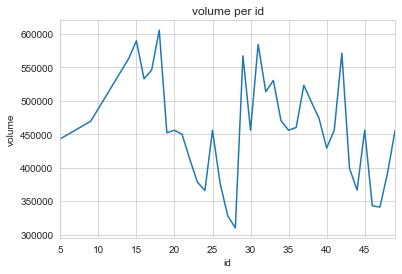

In [35]:
df_imp_derived["volume"].plot();
plt.ylabel('volume');
plt.title("volume per id");
plt.show();

In [36]:
df_imp_derived.columns

Index(['Length', 'Width', 'OuterLength', 'NetWeight', 'volume', 'oltwr'], dtype='object')

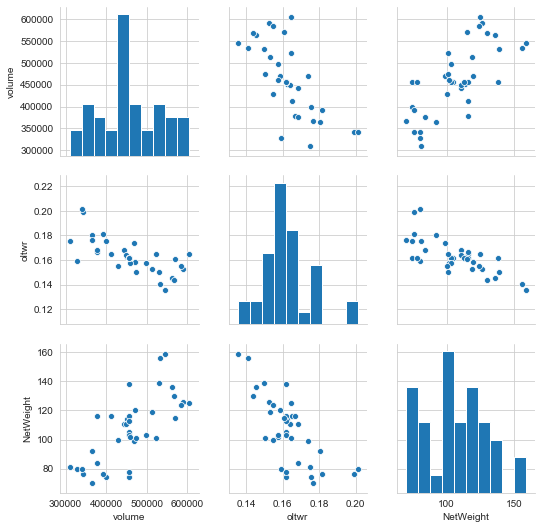

In [37]:
# this plot shows an correlation between volume and netweight
sns.pairplot(df_imp_derived[["volume", "oltwr", "NetWeight"]]);

In [38]:
df_cl_derived.corr()

,Length,Width,OuterLength,NetWeight,volume,oltwr
Length,1.000000,0.513601,0.725993,0.916440,0.617806,-0.665411
Width,0.513601,1.000000,0.784065,0.668372,0.971416,-0.500375
OuterLength,0.725993,0.784065,1.000000,0.873794,0.904614,-0.920354
NetWeight,0.916440,0.668372,0.873794,1.000000,0.779373,-0.786662
volume,0.617806,0.971416,0.904614,0.779373,1.000000,-0.680126
oltwr,-0.665411,-0.500375,-0.920354,-0.786662,-0.680126,1.000000


In [39]:
df_imp_derived.corr()

,Length,Width,OuterLength,NetWeight,volume,oltwr
Length,1.000000,0.522947,0.723190,0.842760,0.620424,-0.670436
Width,0.522947,1.000000,0.797862,0.626128,0.972356,-0.534145
OuterLength,0.723190,0.797862,1.000000,0.804457,0.911564,-0.926361
NetWeight,0.842760,0.626128,0.804457,1.000000,0.723906,-0.728685
volume,0.620424,0.972356,0.911564,0.723906,1.000000,-0.703070
oltwr,-0.670436,-0.534145,-0.926361,-0.728685,-0.703070,1.000000


In [40]:
df_imp_derived.columns

Index(['Length', 'Width', 'OuterLength', 'NetWeight', 'volume', 'oltwr'], dtype='object')

Durch abgeleitete Variablen konnte keine höhere Korrelation erreicht, dennoch neue Information hinzugefügt werden.

### Integrate Data

...

### Format Data

...

## Modeling


### Select Modeling Techniques

Vorgegebene Modeling Technik: [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)  

### Generate Test Design

Vorgabe train/test split ~75/25
```
Datensatz einlesen, train-test-split selbst durchführen:
    Test-Daten: id ist durch 4 teilbar
    Train-Daten: alle anderen
```

ElasticNet maximiert R-squared, zur intuitiveren Unterscheidung soll noch MAE berechnet werden.

Ablauf:

- training auf "train" (Validierung mit CrossValidation durch Algorithmus)
- testing mit "test", entscheidende Metrik: [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)

In [41]:
def make_train_test_split(df):
    """
    returns:
         X_train, X_test, y_train, y_test
    """
    indices_test = [
        idx for idx in df.index.values if idx % 4 == 0
    ]
    test = df[df.index.isin(indices_test)]

    indices_train = [
        idx for idx in df.index.values if idx not in indices_test
    ]
    train = df[df.index.isin(indices_train)]
    X_cols = [col for col in df.columns if col != 'NetWeight']

    return train[X_cols], test[X_cols], \
            train['NetWeight'], test['NetWeight']

### Build Model

#### Datengrundlage / Ansatz

- MVP (minimum viable product)
  - Datenset: originalDatenset
  - Baseline: to beat
- Iteration 1:
  - Datenset: original + imputierte Weight-Werte
- Iteration 2:
  - Datenset: mit abgeleiteten Features
- Iteration 3:
  - Datenset: Kombination Iter. 1 + Iter. 2


Modelling code in func "basic_training_pipeline" von [src ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html) und [src MAE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)

#### try out ridge and or lasso for each dataset

(Bowles, 2015, S.132):
```
 The ElasticNet formulation of the penalized regression problem is to use an adjustable blend of the ridge penalty and the Lasso penalty. ElasticNet introduces another parameter, α, that parameterizes the fraction of the total penalty that is the ridge penalty and the fraction that is Lasso penalty. The end pointα=1corresponds to all Lasso penalty and no ridge penalty.  With the ElasticNet formulation, both λ and  α  must be specifi ed to solve for the coeffi cients for a linear model. Usually, the approach is to pick a value for  α and solve for a range of λ′ f s. You’ll see the computational reasons for that later. ′ In many cases, there’s not a big performance difference betweenα=1andα=0 or some intermediate value of  α . Sometimes it will make a big difference, and it behooves you to check to a few different values of  α  to make sure that you’re not sacrifi cing performance needlessly.
```

In [42]:
def basic_training_pipeline(df, datasetname, l1_ratio=0.5):
    X_train, X_test, y_train, y_test = make_train_test_split(df)
    
    regr = ElasticNetCV(
        l1_ratio=l1_ratio,
        # n_alphas=,
        fit_intercept=True,
        cv=3,
        random_state=13
    )
    regr.fit(X_train, y_train) 
    y_pred = regr.predict(X_test)

    print(datasetname)
    print("train r-squared: {:.3f}".format(
        r2_score(y_train, regr.predict(X_train))
    ))
    print("test r-squared: {:.3f}".format(
        r2_score(y_test, regr.predict(X_test))
    ))
    test_mae = mean_absolute_error(y_test, y_pred)
    print("test MAE: {:.2f}\n".format(
        test_mae
    ))
    return test_mae, regr, y_test, y_pred

4.3 build model + 4.4 Assess model.revised parameter settings

*würde GridSearchCV vorziehen, ElasticNetCV ist jedoch vorgegeben*

In [43]:
test_maes = {}
# iterate over values of L1_ratio (Bowles=alpha)
for l1_ratio in [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1]:
    print("\n\n=== L1-ratio: {} ===".format(l1_ratio))
    for dataset, datasetname in [
        (df_cleaned, "MVP"),
        (df_imp, "Iteration 1 - imputed"),
        (df_cl_derived, "Iteration 2 - derived"),
        (df_imp_derived, "Iteration 3 - imputed + derived"),
    ]:
        test_mae, regr, y_test, y_pred = \
            basic_training_pipeline(dataset, datasetname, l1_ratio)
        test_maes[test_mae] = {
            "regr": regr,
            "y_test": y_test,
            "y_pred": y_pred,
            "l1_ratio": l1_ratio
        }



=== L1-ratio: 0.01 ===
MVP
train r-squared: 0.937
test r-squared: 0.898
test MAE: 6.49

Iteration 1 - imputed
train r-squared: 0.729
test r-squared: 0.912
test MAE: 4.71

Iteration 2 - derived
train r-squared: 0.578
test r-squared: 0.589
test MAE: 13.45

Iteration 3 - imputed + derived
train r-squared: 0.451
test r-squared: 0.638
test MAE: 9.66



=== L1-ratio: 0.05 ===
MVP
train r-squared: 0.941
test r-squared: 0.901
test MAE: 5.53

Iteration 1 - imputed
train r-squared: 0.731
test r-squared: 0.914
test MAE: 4.35

Iteration 2 - derived
train r-squared: 0.578
test r-squared: 0.589
test MAE: 13.45

Iteration 3 - imputed + derived
train r-squared: 0.451
test r-squared: 0.638
test MAE: 9.66



=== L1-ratio: 0.1 ===
MVP
train r-squared: 0.941
test r-squared: 0.901
test MAE: 5.51

Iteration 1 - imputed
train r-squared: 0.732
test r-squared: 0.914
test MAE: 4.32

Iteration 2 - derived
train r-squared: 0.578
test r-squared: 0.589
test MAE: 13.45

Iteration 3 - imputed + derived
train r-squa

In [44]:
min_mae = min(test_maes.keys())
print("min MAE: {:.3f}".format(min_mae))
best_regr = test_maes[min_mae]
best_l1 = best_regr["l1_ratio"]
y_test = best_regr["y_test"]
y_pred = best_regr["y_pred"]

min MAE: 4.291


### Assess Model


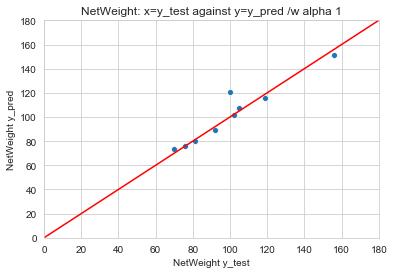

In [45]:
plt.plot([0,200],[0,200], color="r");
ax = sns.scatterplot(
    x=y_test,
    y=y_pred,
);
ax.set_ylim(0,180);
ax.set_xlim(0,180);
ax.set_title("NetWeight: x=y_test against y=y_pred /w alpha {}".format(best_l1));
ax.set_xlabel("NetWeight y_test");
ax.set_ylabel("NetWeight y_pred");

#### Model assessment

Model ist mit "imputed" values besser, als das gecleante standard Datenset. Gleichzeit schneidet das Model mit mehr Information schlechter ab (#curseofdimensionality).

Zu untersuchen: Wird Model rein durch hinzunahme von Trainingsdaten besser?
  - ja: sammle / generiere (AutoEncoder) mehr Beispiele | für Deployment: trainiere auf gesamten Datenset
  - nein: Model

Alpha: 0.9 ist eher eine L1-penalty (Lasso)

**Ergebnis**:

- der MAE wird kleiner mit steigender Trainingsgröße
- legt somit nahe weitere Daten zu beschaffen.

In [46]:
# [i/100 for i in range(10,110,10)]

In [47]:
# df_imp.iloc[0:int(len(df_imp)*0.1), :]

In [48]:
def model_eval_training_pipeline(df, datasetname, l1_ratio=0.5):
    # reusing building_training_pipeline
    X_train, X_test, y_train, y_test = make_train_test_split(df)
    
    results = {}
    for i in [i/100 for i in range(30,110,10)]:
        regr = ElasticNetCV(
            l1_ratio=l1_ratio,
            # n_alphas=,
            fit_intercept=True,
            cv=3,
            random_state=13
        )
        sep = int(len(X_train)*i)
        X_train_frac = X_train.iloc[0:sep, :]
        y_train_frac = y_train.iloc[0:sep]
        
        regr.fit(X_train_frac, y_train_frac) 
        y_pred = regr.predict(X_test)

        print(i, l1_ratio, datasetname)
        print("train r-squared: {:.3f}".format(
            r2_score(y_train_frac, regr.predict(X_train_frac))
        ))
        print("test r-squared: {:.3f}".format(
            r2_score(y_test, regr.predict(X_test))
        ))
        test_mae = mean_absolute_error(y_test, y_pred)
        print("test MAE: {:.2f}\n".format(
            test_mae
        ))
        results[i] = pd.DataFrame({
            "test_mae": test_mae,
            "regr": regr,
            "y_test": y_test,
            "y_pred": y_pred
        })
    return results

In [49]:
test_maes = {}

for dataset, datasetname in [
    (df_imp, "Iteration 1 - imputed"),
]:
    df_mod_ass = \
        model_eval_training_pipeline(dataset, datasetname, 0.05)

0.3 0.05 Iteration 1 - imputed
train r-squared: 0.993
test r-squared: 0.821
test MAE: 8.56

0.4 0.05 Iteration 1 - imputed
train r-squared: 0.956
test r-squared: 0.815
test MAE: 8.76

0.5 0.05 Iteration 1 - imputed
train r-squared: 0.969
test r-squared: 0.885
test MAE: 5.12

0.6 0.05 Iteration 1 - imputed
train r-squared: 0.854
test r-squared: 0.824
test MAE: 8.20

0.7 0.05 Iteration 1 - imputed
train r-squared: 0.836
test r-squared: 0.854
test MAE: 6.87

0.8 0.05 Iteration 1 - imputed
train r-squared: 0.823
test r-squared: 0.865
test MAE: 6.16

0.9 0.05 Iteration 1 - imputed
train r-squared: 0.734
test r-squared: 0.903
test MAE: 4.61

1.0 0.05 Iteration 1 - imputed
train r-squared: 0.731
test r-squared: 0.914
test MAE: 4.35



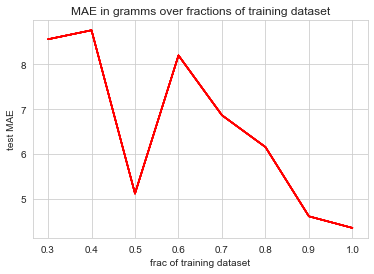

In [50]:
maes = [ df_mod_ass[i]["test_mae"] for i in [i/100 for i in range(30,110,10)]]

plt.plot(
    [i/100 for i in range(30,110,10)],
    maes,
    color='r'
);
plt.title("MAE in gramms over fractions of training dataset");
plt.xlabel("frac of training dataset");
plt.ylabel("test MAE");

#### Hypothese:

Da zuvor l1_ratio bei knapp 1 lag, d.h. L1-Norm, kann man den Algorithmus unterstützen indem man die Featureanzahl reduziert, dabei mittels den HauptkomponentenAnalyse Informationen erhält.

##### Ergebnis

Keine Verbesserung. Ggf. erst bei höherer Datenmenge nützlich.

In [51]:
def pca_training_pipeline(df, datasetname, l1_ratio=0.5):
    X_train, X_test, y_train, y_test = make_train_test_split(df)
    
    pca = PCA(n_components=2)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    regr = ElasticNetCV(
        l1_ratio=l1_ratio,
        # n_alphas=,
        fit_intercept=True,
        cv=3,
        random_state=13
    )
    regr.fit(X_train, y_train) 
    y_pred = regr.predict(X_test)

    print(datasetname)
    print("train r-squared: {:.3f}".format(
        r2_score(y_train, regr.predict(X_train))
    ))
    print("test r-squared: {:.3f}".format(
        r2_score(y_test, regr.predict(X_test))
    ))
    test_mae = mean_absolute_error(y_test, y_pred)
    print("test MAE: {:.2f}\n".format(
        test_mae
    ))
    return test_mae, regr, y_test, y_pred

In [52]:
test_maes = {}
# iterate over values of L1_ratio (Bowles=alpha)
for l1_ratio in [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1]:
    print("\n\n=== L1-ratio: {} ===".format(l1_ratio))
    for dataset, datasetname in [
        (df_cleaned, "MVP"),
        (df_imp, "Iteration 1 - imputed"),
        (df_cl_derived, "Iteration 2 - derived"),
        (df_imp_derived, "Iteration 3 - imputed + derived"),
    ]:
        test_mae, regr, y_test, y_pred = \
            pca_training_pipeline(dataset, datasetname, l1_ratio)
        test_maes[test_mae] = {
            "regr": regr,
            "y_test": y_test,
            "y_pred": y_pred,
            "l1_ratio": l1_ratio
        }



=== L1-ratio: 0.01 ===
MVP
train r-squared: 0.935
test r-squared: 0.896
test MAE: 6.82

Iteration 1 - imputed
train r-squared: 0.728
test r-squared: 0.911
test MAE: 4.90

Iteration 2 - derived
train r-squared: 0.578
test r-squared: 0.589
test MAE: 13.45

Iteration 3 - imputed + derived
train r-squared: 0.451
test r-squared: 0.638
test MAE: 9.66



=== L1-ratio: 0.05 ===
MVP
train r-squared: 0.940
test r-squared: 0.901
test MAE: 5.61

Iteration 1 - imputed
train r-squared: 0.731
test r-squared: 0.914
test MAE: 4.39

Iteration 2 - derived
train r-squared: 0.578
test r-squared: 0.589
test MAE: 13.45

Iteration 3 - imputed + derived
train r-squared: 0.451
test r-squared: 0.638
test MAE: 9.66



=== L1-ratio: 0.1 ===
MVP
train r-squared: 0.941
test r-squared: 0.901
test MAE: 5.44

Iteration 1 - imputed
train r-squared: 0.732
test r-squared: 0.914
test MAE: 4.34

Iteration 2 - derived
train r-squared: 0.578
test r-squared: 0.589
test MAE: 13.45

Iteration 3 - imputed + derived
train r-squa

min MAE: 4.292


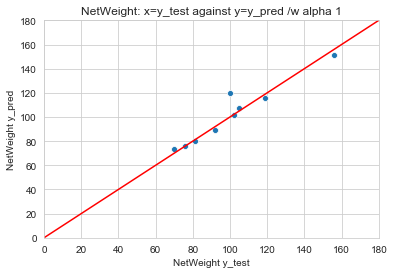

In [53]:
min_mae = min(test_maes.keys())
print("min MAE: {:.3f}".format(min_mae))
best_regr = test_maes[min_mae]
best_l1 = best_regr["l1_ratio"]
y_test = best_regr["y_test"]
y_pred = best_regr["y_pred"]

plt.plot([0,200],[0,200], color="r");
ax = sns.scatterplot(
    x=y_test,
    y=y_pred,
);
ax.set_ylim(0,180);
ax.set_xlim(0,180);
ax.set_title("NetWeight: x=y_test against y=y_pred /w alpha {}".format(best_l1));
ax.set_xlabel("NetWeight y_test");
ax.set_ylabel("NetWeight y_pred");

## Evaluate results

### Evaluate results

Die Zielvorgabe von +/- 5% konnte knapp erreicht werden. Das Model ist somit in der derzeitigen Form verwendbar!  

Empfehlung:  
Da die gegebene Datenmenge überschaubar ist, empfiehlt es sich weitere Beispieldaten zu generieren.  
Wahlweise könnte man auch mit einem Autoencoder die Datenmenge künstlich erweitern. Die wenigen Features mit einigermaßen normalverteilung (ausgen. "Length") würden sich dafür anbieten.

Durch weitere Daten könnten ebenfalls die generierten features mehr Aussagekraft bieten (bisher immer schlechter (r-squared, mae) als StandardFeatures ...).

In [54]:
print(
    "bestes Modell hat mit {:.2f}g eine Abweichung von {:.1f}% ggü. der Gesamt-Gewicht-Bandbreite".format(
        min_mae,
        ( min_mae / (
            max(df['NetWeight']) - min(df['NetWeight'])
        )) * 100
    )
)
print(
    "Mit +/-{:.2f}g entspricht dies einer Abweichung von {:.1f}% ggü. dem mittleren Gewicht von {:.0f}g".format(
        min_mae,
        ( ( min_mae * 2) / (
            df['NetWeight'].mean())
        )* 100,
        df['NetWeight'].mean()
    ) 
)
print(
    "+/-{:.2f}g entspricht {:.1f}% ggü. dem geringsten Gewicht von {:.0f}g".format(
        min_mae,
        ( min_mae * 2) / (
            df['NetWeight'].min()
        ) * 100,
        df['NetWeight'].min()
    ) 
)

bestes Modell hat mit 4.29g eine Abweichung von 4.8% ggü. der Gesamt-Gewicht-Bandbreite
Mit +/-4.29g entspricht dies einer Abweichung von 8.0% ggü. dem mittleren Gewicht von 107g
+/-4.29g entspricht 12.3% ggü. dem geringsten Gewicht von 70g


### Review

Alle Schritte (inkl. feature generation) wurden mit den erlaubten Parametern ausgeführt. Das Endergebnis wurde nicht verfälscht durch ein enkodiertes-NetWeight feature.  
Weitere Schritte siehe "Evaluate Results"

## Deployment

**kein deployment geplant**

### angestrebte Architektur

DockerContainer mit RestAPI (fastAPI+guvicorn) mit gepickeltem Model-file. Deployment z.B. in Azure Container Instances, oder Kubernetes Cluster - je nach zu erwartendem traffic ;-) .